In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set the style for the plots
sns.set_palette("viridis")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.grid'] = True

import sys

src_root = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_root not in sys.path:
    sys.path.append(src_root)

In [2]:
# Load the external dataset
def load_data(filepath, name):
    df = pd.read_csv(filepath)
    print(f"{name} data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")
    return df

external = load_data("../data/interim/cleaned_external_data.csv", "external")

external data loaded successfully with 2029 rows and 3 columns.


# Exploratory Data Analysis


## Data Summary


In [3]:
# Get the descriptive statistics
external.describe()

,Tg,Ta,Tc
count,2029.000000,2029.000000,2029.000000
mean,34.368379,24.107541,37.029428
std,0.738554,1.324160,0.510204
min,30.225000,20.200000,35.540000
25%,33.955000,23.400000,36.790000
50%,34.387500,24.000000,36.940000
75%,34.787500,24.700000,37.140000
max,37.693333,29.100000,40.340000


In [4]:
from eda import dataframe_summary

# Get the detailed summary
dataframe_summary(external)


--- Dataframe Summary ---


,Data Type,Non-Null Count,Missing Values,Distinct Values,Zeros Count,Negative Values,Infinite Values
Tg,float64,2029,0,1215,0,0,0
Ta,float64,2029,0,78,0,0,0
Tc,float64,2029,0,70,0,0,0


## Distribution Analysis



--- Distribution Analysis ---

Normality Tests (Shapiro-Wilk):
Tg: test statistic = 0.9794, p-value = 1.5013e-16
  The distribution of Tg is likely not normal (p < 0.05)
Ta: test statistic = 0.9646, p-value = 6.8309e-22
  The distribution of Ta is likely not normal (p < 0.05)
Tc: test statistic = 0.8392, p-value = 3.1533e-41
  The distribution of Tc is likely not normal (p < 0.05)


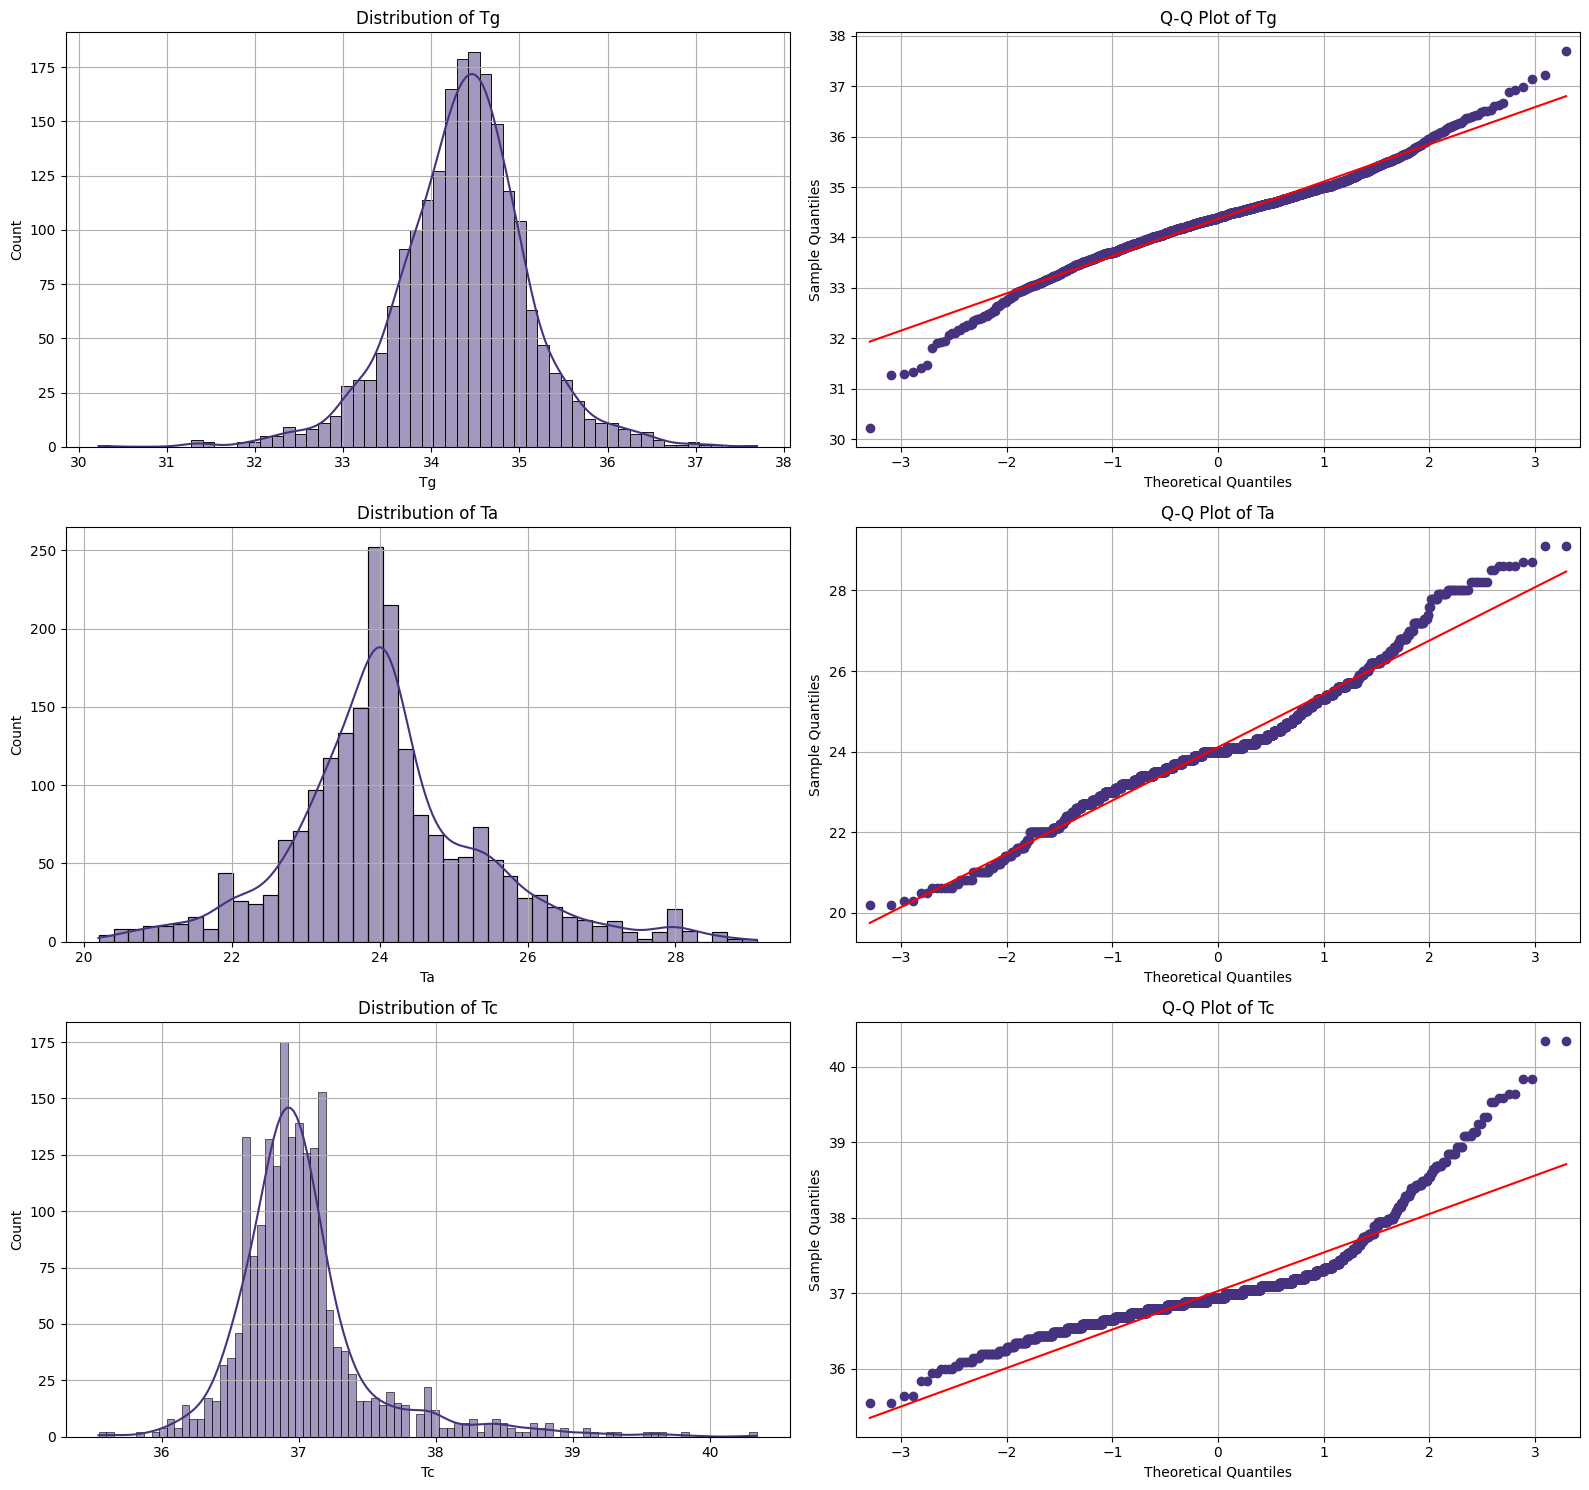

In [5]:
from eda import distribution_analysis

distribution_analysis(external)

## Correlation Analysis



--- Correlation Analysis ---

Correlation Matrix:
       Tg     Ta     Tc
Tg  1.000  0.355  0.548
Ta  0.355  1.000  0.098
Tc  0.548  0.098  1.000

Pearson Correlation Coefficients:
Tg vs Tc: r = 0.5482, p-value = 1.6529e-159
  The correlation between Tg and Tc is statistically significant
Ta vs Tc: r = 0.0976, p-value = 1.0718e-05
  The correlation between Ta and Tc is statistically significant

Spearman Rank Correlation Coefficients:
Tg vs Tc: rho = 0.4274, p-value = 6.4331e-91
Ta vs Tc: rho = 0.1016, p-value = 4.5605e-06


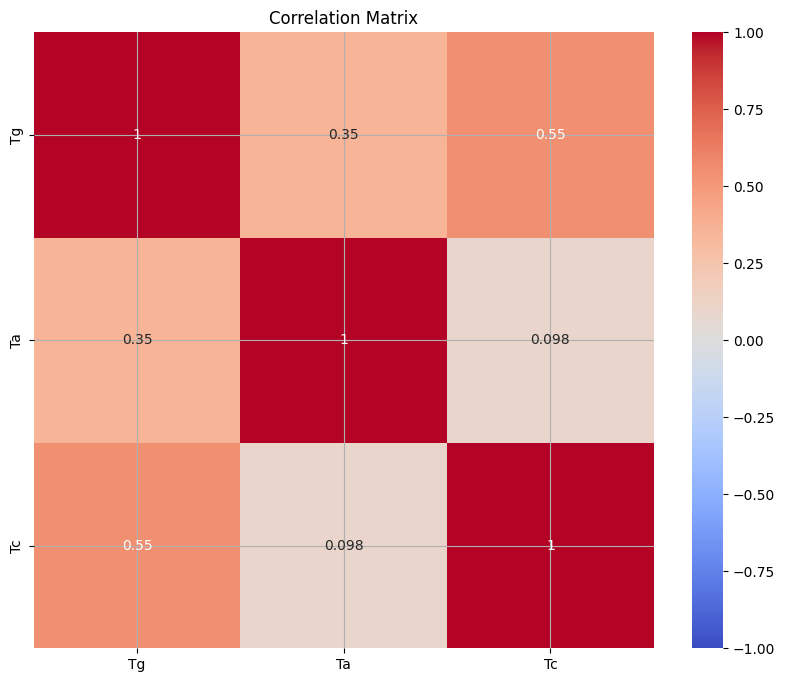

<Figure size 1500x1000 with 0 Axes>

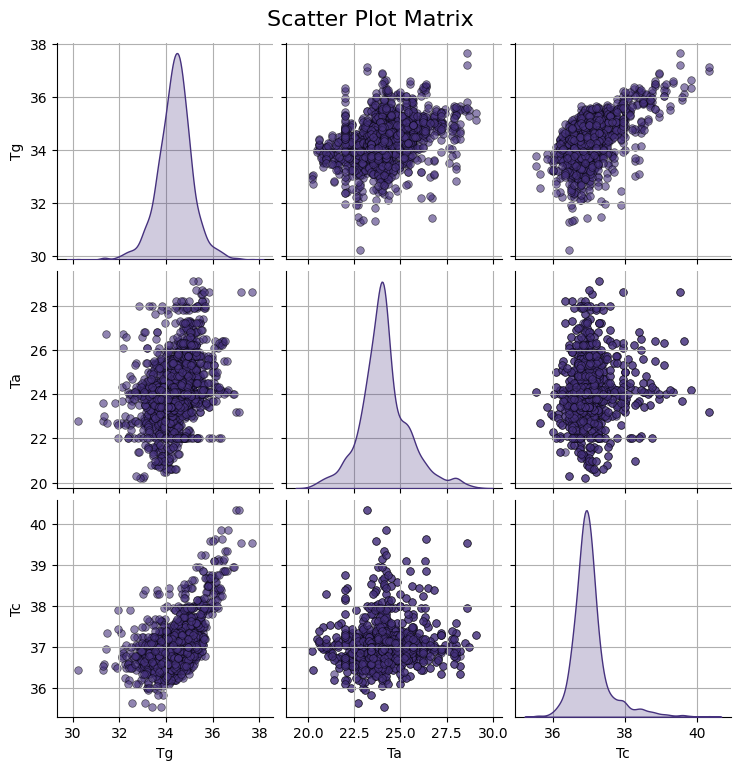

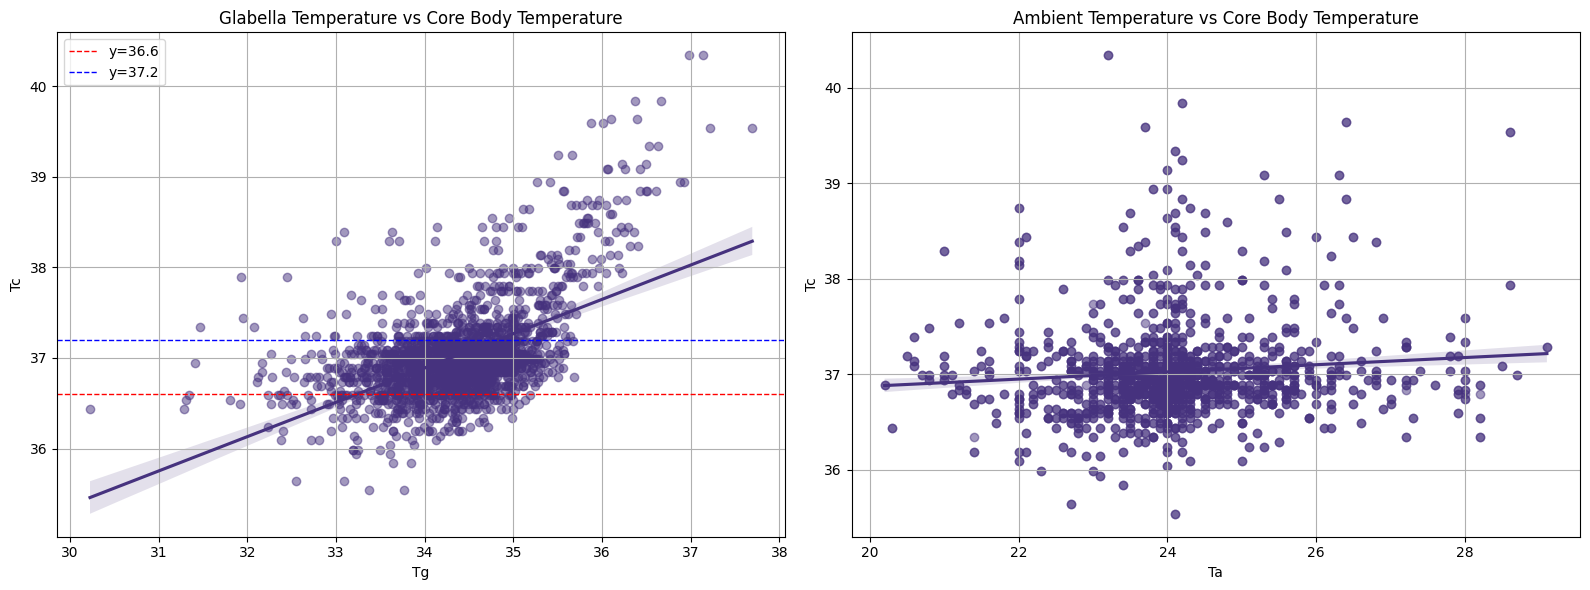

In [6]:
from eda import correlation_analysis

correlation_analysis(external)

## Outlier Analysis

Normal body temperature is considered to be **36. 6°C** to **37. 2°C** or 98-99°F. Any temperature higher than this range is considered to be fever. Note that evening temperature is higher than the normal.

Dr. Anet Varghese
4 years exp · India · Doctor Of Medicine (MBBS)


--- Outlier Analysis ---

Tg - Outliers detected: 81
Lower bound: 32.71, Upper bound: 36.04
Outlier values:
[30.225      31.28       31.3025     31.34       31.4125     31.46333333
 31.8075     31.9125     31.93       31.955      32.07       32.11333333
 32.115      32.1675     32.2275     32.23       32.2625     32.2775
 32.35       32.3625     32.375      32.39       32.405      32.4125
 32.435      32.4475     32.45       32.49       32.49       32.51
 32.53       32.54333333 32.55       32.6225     32.63333333 32.645
 32.65       32.6675     32.68       36.04       36.05       36.065
 36.08       36.08666667 36.0925     36.105      36.11666667 36.155
 36.1675     36.18333333 36.195      36.2125     36.22       36.2275
 36.25       36.2625     36.27333333 36.2925     36.32       36.36
 36.3675     36.395      36.405      36.4225     36.425      36.495
 36.4975     36.5075     36.53       36.60666667 36.6275     36.66
 36.88       36.92       36.975      37.13666667 37.2125     37.6

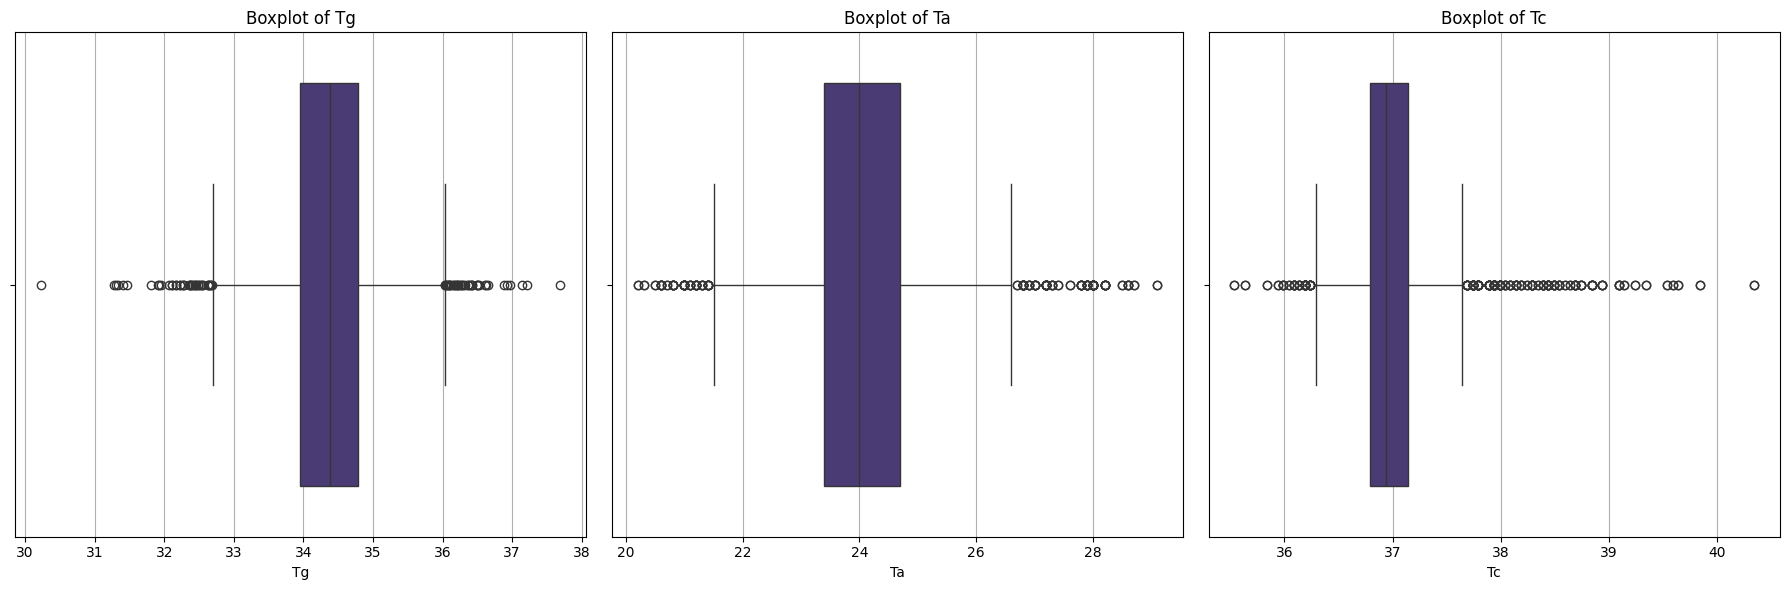

{'Tg':              Tg    Ta     Tc
 74    32.530000  23.7  36.79
 81    36.092500  24.8  38.59
 99    32.262500  22.7  36.49
 122   36.975000  23.2  40.34
 156   36.105000  26.4  39.64
 ...         ...   ...    ...
 1933  32.645000  23.8  37.24
 1956  32.680000  24.1  36.59
 1978  32.667500  25.3  36.79
 2007  36.273333  24.3  38.74
 2011  32.262500  26.6  37.04
 
 [81 rows x 3 columns],
 'Ta':              Tg    Ta     Tc
 298   34.952500  27.0  36.74
 303   32.167500  26.7  36.94
 305   35.375000  26.8  37.24
 306   35.552500  26.9  37.59
 307   34.362500  27.2  36.34
 ...         ...   ...    ...
 2012  35.206667  27.9  36.79
 2014  35.605000  27.9  37.19
 2015  34.385000  27.9  36.59
 2016  34.900000  27.9  36.84
 2026  35.646667  28.0  37.59
 
 [140 rows x 3 columns],
 'Tc':              Tg    Ta     Tc
 14    34.882500  23.5  37.79
 22    34.170000  23.1  36.14
 43    33.500000  23.0  35.99
 59    34.952500  23.4  37.79
 66    35.462500  23.2  37.99
 ...         ...   ...    ...

In [7]:
from eda import outlier_analysis

outlier_analysis(external)

#### Greater than 37.2

A temperature greater than 37.2 indicates fever data or higher-than-normal temperature records.

In [8]:
# ogtnt means "out of the normal temperature"
ogtnt = external[external['Tc'] > 37.2].copy() # Temperature greater than 37.2 degrees Celsius


--- Outlier Analysis ---

Tg - Outliers detected: 11
Lower bound: 32.88, Upper bound: 37.03
Outlier values:
[31.46333333 31.93       31.955      32.07       32.45       32.6225
 32.645      32.7725     37.13666667 37.2125     37.69333333]

Ta - Outliers detected: 20
Lower bound: 21.25, Upper bound: 27.25
Outlier values:
[20.6 20.8 21.  21.2 27.8 28.  28.6 29.1]

Tc - Outliers detected: 20
Lower bound: 36.37, Upper bound: 38.97
Outlier values:
[39.09 39.14 39.24 39.34 39.54 39.59 39.64 39.84 40.34]

Outlier detection using Z-scores (|z| > 3):
Tg: 5 outliers detected by Z-score method
Ta: 6 outliers detected by Z-score method
Tc: 10 outliers detected by Z-score method


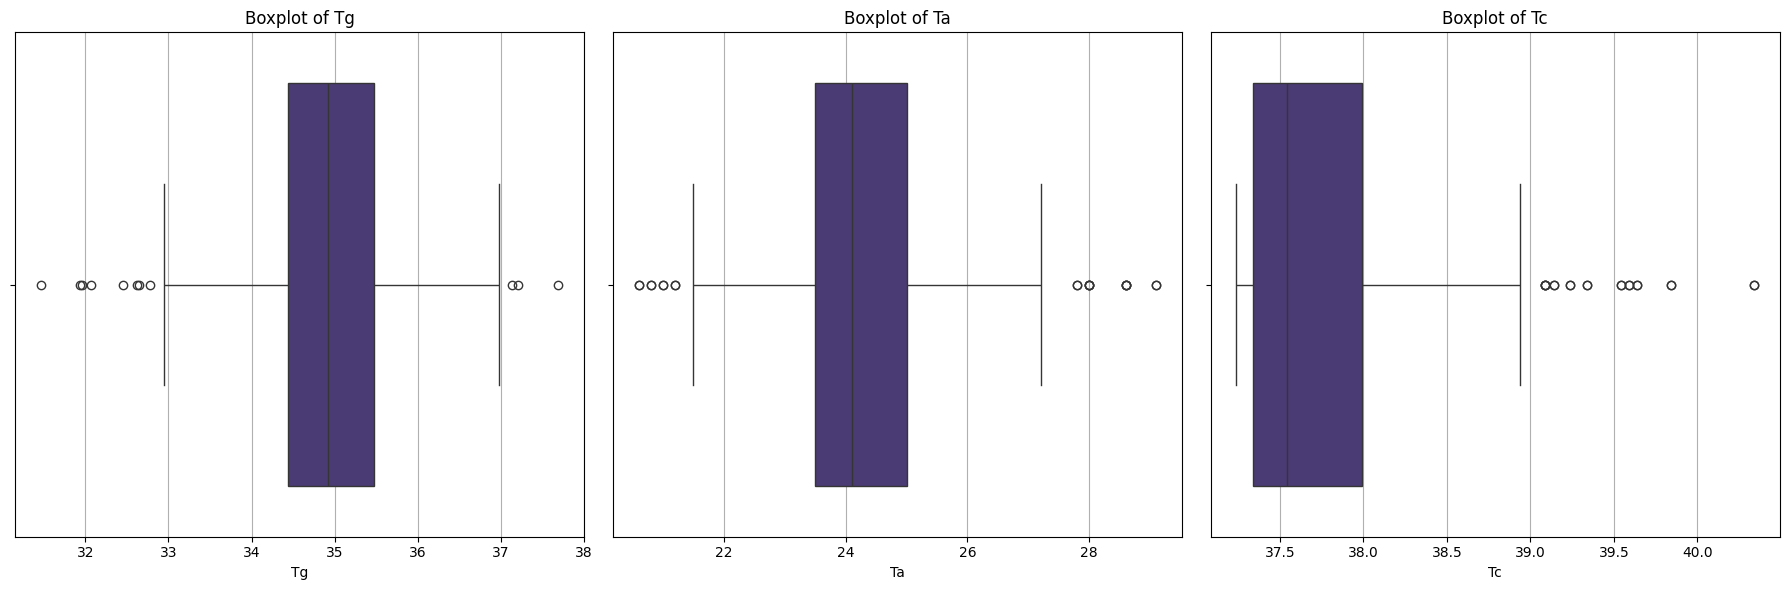

In [9]:
ogt_outliers = outlier_analysis(ogtnt)

In [10]:
ogt_outliers['Tg'][ogt_outliers['Tg']['Tg'] < 32.88]

# Fail
# Assumed cold ambient temperature affected core body temperature or subjects had fever

,Tg,Ta,Tc
215,32.070000,22.7,37.34
272,32.450000,22.6,37.89
624,32.622500,22.0,37.44
1238,31.463333,22.7,37.34
1292,31.930000,22.6,37.89
1632,31.955000,22.0,37.44
1922,32.772500,23.9,37.24
1933,32.645000,23.8,37.24


In [11]:
ogt_outliers['Tc'][ogt_outliers['Tc']['Tc'] > 38.97]

# To keep

,Tg,Ta,Tc
122,36.975000,23.2,40.34
156,36.105000,26.4,39.64
490,36.425000,26.3,39.09
645,36.367500,24.2,39.84
648,35.877500,23.7,39.59
712,36.530000,24.1,39.34
761,36.227500,24.0,39.14
799,37.212500,28.6,39.54
839,36.065000,25.3,39.09
845,35.655000,24.2,39.24


In [12]:
modified_ogtnt = ogtnt[~ogtnt.index.isin(ogtnt[(ogtnt['Tg'] >= 33) & (ogtnt['Tg'] <= 34) & (ogtnt['Tc'] >= 38)].index)]
modified_ogtnt = modified_ogtnt[~modified_ogtnt.index.isin(ogt_outliers['Tg'][ogt_outliers['Tg']['Tg'] < 32.88].index)]

#### Within 36.6 to 37.2 Range

A temperature within the range of 36.6 to 37.2 degrees is often considered typical for the human body.

In [13]:
# ont means "on the normal temperature"
ont = external[(external['Tc'] >= 36.6) & (external['Tc'] <= 37.2)].copy()


--- Outlier Analysis ---

Tg - Outliers detected: 28
Lower bound: 32.95, Upper bound: 35.73
Outlier values:
[31.4125     32.11333333 32.115      32.1675     32.2625     32.2775
 32.4125     32.435      32.49       32.53       32.63333333 32.65
 32.6675     32.70666667 32.72       32.77       32.785      32.8025
 32.83       32.835      32.84       32.8925     32.895      32.9175
 32.92       32.9425     32.945     ]

Ta - Outliers detected: 111
Lower bound: 21.70, Upper bound: 26.50
Outlier values:
[20.2 20.5 20.6 20.7 20.8 21.  21.1 21.2 21.3 21.4 21.5 21.6 26.6 26.7
 26.8 26.9 27.  27.2 27.3 27.4 27.6 27.8 27.9 28.  28.2 28.5 28.7]

Tc - Outliers detected: 0
Lower bound: 36.41, Upper bound: 37.41

Outlier detection using Z-scores (|z| > 3):
Tg: 11 outliers detected by Z-score method
Ta: 18 outliers detected by Z-score method
Tc: 0 outliers detected by Z-score method


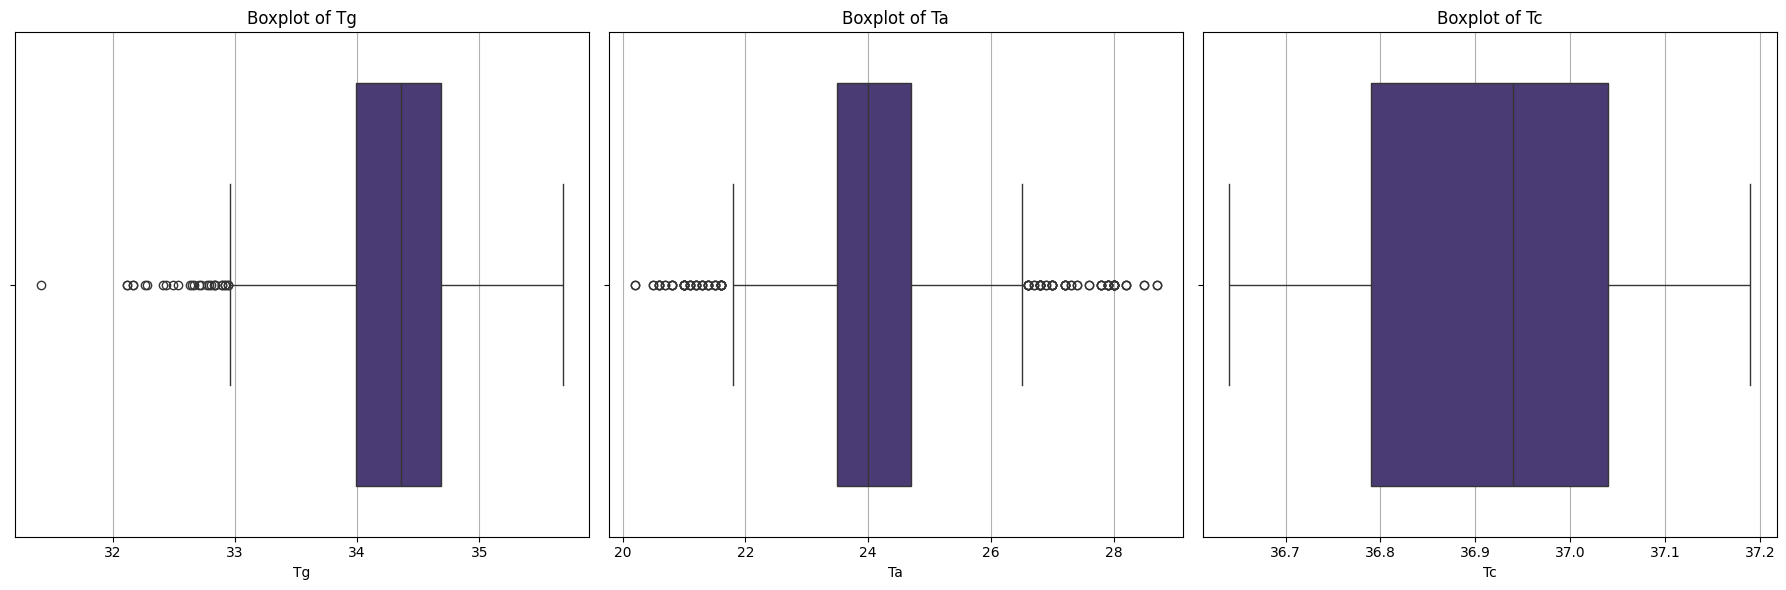

In [14]:
ont_outliers = outlier_analysis(ont)

In [15]:
ont_outliers['Tg'][ont_outliers['Tg']['Tg'] < 32.95]

# Fail

,Tg,Ta,Tc
74,32.530000,23.7,36.79
303,32.167500,26.7,36.94
374,32.785000,21.4,36.69
654,32.942500,23.8,36.64
813,32.892500,24.4,36.79
921,32.840000,23.5,36.99
1034,32.945000,23.0,36.74
1097,32.115000,23.7,36.79
1146,32.650000,22.8,36.99
1181,32.167500,26.1,36.84


In [16]:
ont_outliers['Tg'][ont_outliers['Tg']['Tg'] > 35.73]

# Fail

,Tg,Ta,Tc


In [17]:
modified_ont = ont[~ont.index.isin(ont_outliers['Tg'][ont_outliers['Tg']['Tg'] < 32.95].index)]
modified_ont = modified_ont[~modified_ont.index.isin(ont_outliers['Tg'][ont_outliers['Tg']['Tg'] > 35.73].index)]